In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requi

In [2]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

# We have to check which Torch version for Xformers (2.3 -> 0.0.27)
from torch import __version__; from packaging.version import Version as V
xformers = "xformers==0.0.27" if V(__version__) < V("2.4.0") else "xformers"
!pip install --no-deps {xformers} trl peft accelerate bitsandbytes triton

In [3]:
import torch
from unsloth import FastLanguageModel
from peft import LoftQConfig

# Check CUDA compatibility (optional, but good practice)
major_version, minor_version = torch.cuda.get_device_capability()
print(f"Major: {major_version}, Minor: {minor_version}")

# Define model parameters
max_seq_length = 12000  # Set based on your token count range (9k to 11.5k tokens)
dtype = None  # Automatically detect dtype
load_in_4bit = True  # Use 4-bit quantization to reduce memory usage

# Load the pre-trained LLaMA 3.1 model with 4-bit quantization
model_name = "unsloth/Meta-Llama-3.1-8B-bnb-4bit"
# model_name = "unsloth/gemma-2-9b-bnb-4bit"
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)

# Apply PEFT (Parameter-Efficient Fine-Tuning) with LoRA
model = FastLanguageModel.get_peft_model(
    model,
    r=16,  # LoRA rank; can be adjusted based on your needs
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",  # Key transformer layers
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha=16,
    lora_dropout=0,  # No dropout for optimal training
    bias="none",  # Bias optimization
    use_gradient_checkpointing="unsloth",  # Gradient checkpointing for memory efficiency
    random_state=3407,
    use_rslora=True,  # Use rank-stabilized LoRA
    # loftq_config = LoftQConfig(loftq_bits=4, loftq_iter=1),  # Enable if you want to use LoftQ
)

# Print the number of trainable parameters for verification
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Major: 8, Minor: 0
==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.27. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Trainable parameters: 41943040


In [4]:
import pandas as pd
from datasets import Dataset

# Load the dataset
file_path = './train_dataset.csv'
data = pd.read_csv(file_path)

# Identify the roles that need undersampling
roles_to_undersample = ['communications', 'ops-or-gtm']

# Set the number of samples to retain for undersampled roles
samples_to_keep = 2  # Adjust this number as needed

# Initialize an empty DataFrame to store the processed data
undersampled_data = pd.DataFrame()

# Process each role in the dataset
for role, group in data.groupby('role'):
    if role in roles_to_undersample:
        # Randomly sample the specified number of instances for the role
        sampled_group = group.sample(n=samples_to_keep, random_state=42)
    else:
        # Keep all instances of the role
        sampled_group = group

    # Append the sampled group to the undersampled_data DataFrame
    undersampled_data = pd.concat([undersampled_data, sampled_group])

# Ensure the resulting DataFrame is shuffled
undersampled_data = undersampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the processed data to a new CSV file (optional)
undersampled_data.to_csv('undersampled_train_dataset.csv', index=False)

# Convert the processed DataFrame back to a Hugging Face Dataset
dataset = Dataset.from_pandas(undersampled_data)

# Output the processed dataset to verify
dataset


Dataset({
    features: ['candidateAId', 'candidateBId', 'winnerId', 'candidateATranscript', 'candidateBTranscript', 'candidateAResume', 'candidateBResume', 'role'],
    num_rows: 18
})

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the undersampled dataset
file_path = './undersampled_train_dataset.csv'
data = pd.read_csv(file_path)

# Define roles and winner_A
roles = data['role']
winner_A = data['winnerId'] == data['candidateAId']

# Prepare the data
role_counts = roles.value_counts()
total_samples = role_counts.sum()

role_winner_counts = pd.crosstab(roles, winner_A)
role_winner_counts.columns = ['Candidate B Wins', 'Candidate A Wins']
role_winner_counts = role_winner_counts.loc[role_winner_counts.sum(axis=1).sort_values(ascending=False).index]


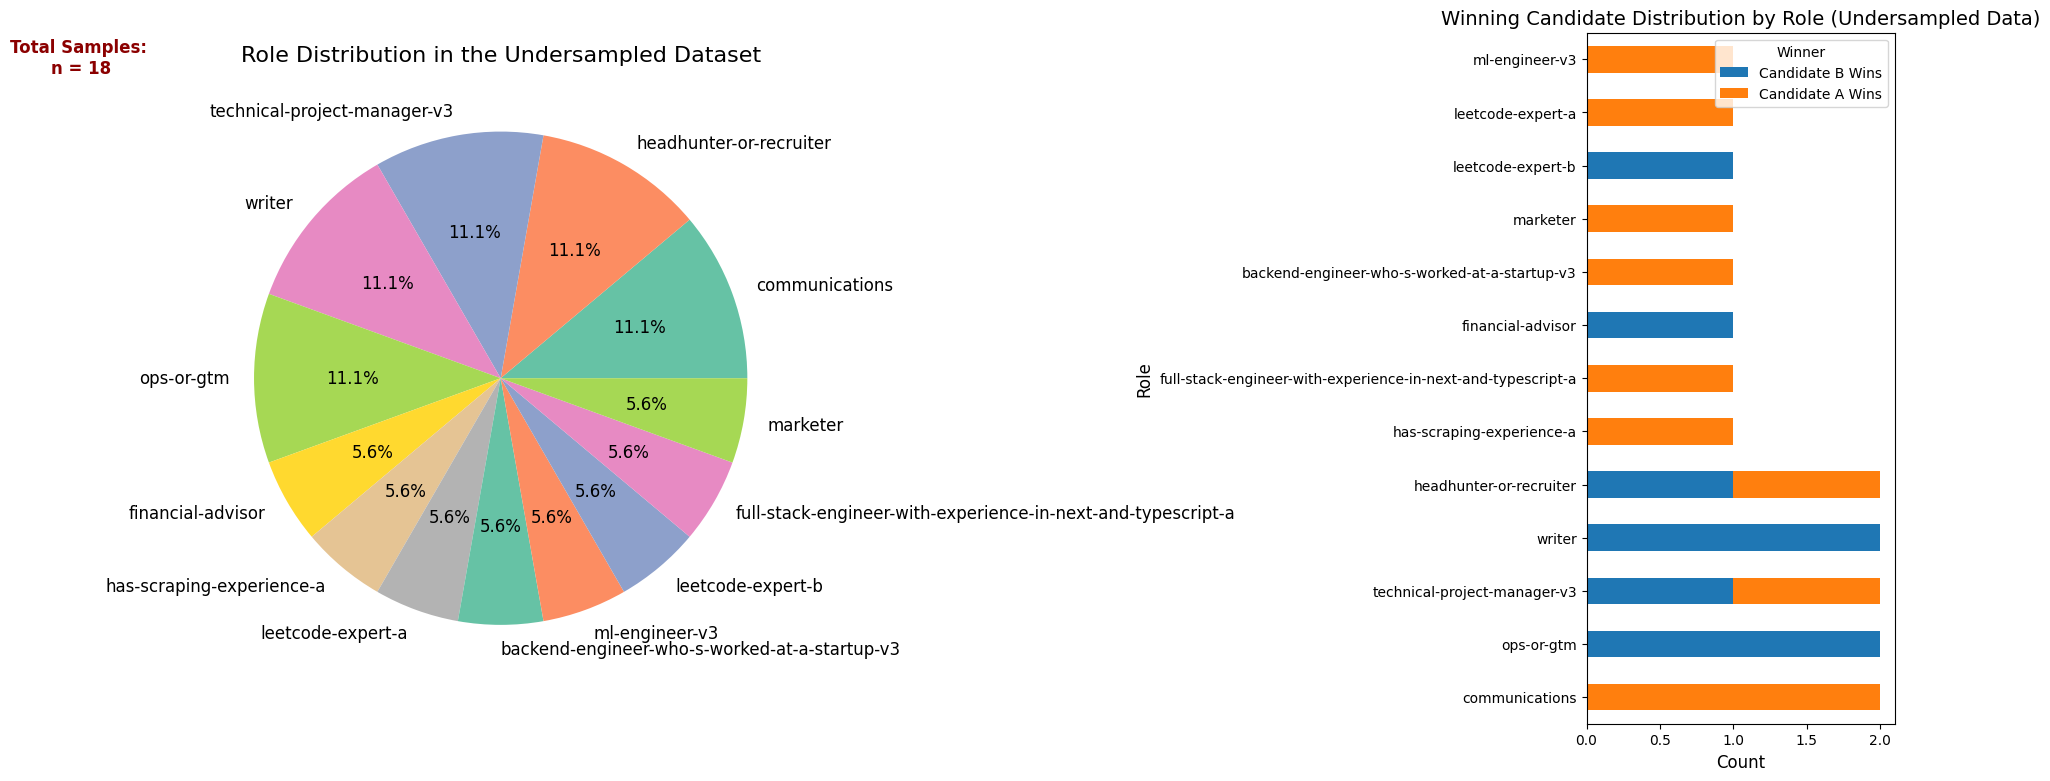

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the undersampled dataset
file_path = './undersampled_train_dataset.csv'
data = pd.read_csv(file_path)

# Define roles and winner_A
roles = data['role']
winner_A = data['winnerId'] == data['candidateAId']

# Prepare the data
role_counts = roles.value_counts()
total_samples = role_counts.sum()

role_winner_counts = pd.crosstab(roles, winner_A)
role_winner_counts.columns = ['Candidate B Wins', 'Candidate A Wins']
role_winner_counts = role_winner_counts.loc[role_winner_counts.sum(axis=1).sort_values(ascending=False).index]

# Create a figure with subplots, adjusting the size ratio between the two plots
fig, axs = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [2, 1]})

# Plot 1: Pie chart
axs[0].pie(
    role_counts,
    labels=role_counts.index,
    autopct='%1.1f%%',
    colors=sns.color_palette('Set2', len(role_counts)),
    textprops={'fontsize': 12}
)
axs[0].set_title('Role Distribution in the Undersampled Dataset', fontsize=16)

# Add text annotation
axs[0].text(
    -1.7, 1.3,
    f'Total Samples: \nn = {total_samples}',
    fontsize=12, ha='center', va='center',
    color='darkred',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
    fontweight='bold'
)

# Plot 2: Stacked bar chart
role_winner_counts.plot(kind='barh', stacked=True, color=['#1f77b4', '#ff7f0e'], ax=axs[1])
axs[1].set_title('Winning Candidate Distribution by Role (Undersampled Data)', fontsize=14)
axs[1].set_xlabel('Count', fontsize=12)
axs[1].set_ylabel('Role', fontsize=12)
axs[1].legend(title='Winner', loc='upper right')

# Adjust layout to ensure everything fits
plt.tight_layout()

# Save the combined figure
plt.savefig('combined_role_distribution_and_winner_distribution_large_pie_undersampled.jpeg', dpi=300)

# Show the plot
plt.show()


In [7]:
from datasets import load_dataset

# Load your dataset from the CSV file
dataset = load_dataset('csv', data_files='undersampled_train_dataset.csv')['train']

Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
role_prompt = """Choose the one candidate for the role of: {role_name}, you have two candidate options, where the profile of
### Candidate A has done this interview and their academic profile with resume : {candidate_A_profile},
### Candidate B has done this interview and their academic profile with resume : {candidate_B_profile},
which candidate do you prefer for the role of {role_name}?
### Answer: {true_value}
"""

EOS_TOKEN = "<|endoftext|>"

def formatting_prompts_func(examples):
    roles = examples['role']
    candidate_A_transcripts = examples['candidateATranscript']
    candidate_B_transcripts = examples['candidateBTranscript']
    candidate_A_resumes = examples['candidateAResume']
    candidate_B_resumes = examples['candidateBResume']
    winner_ids = examples['winnerId']
    candidate_A_ids = examples['candidateAId']

    texts = []
    for role, A_transcript, B_transcript, A_resume, B_resume, winner_id, A_id in zip(
        roles, candidate_A_transcripts, candidate_B_transcripts, candidate_A_resumes, candidate_B_resumes, winner_ids, candidate_A_ids
    ):
        candidate_A_profile = f"Candidate A Transcript: {A_transcript}\nCandidate A Resume: {A_resume}"
        candidate_B_profile = f"Candidate B Transcript: {B_transcript}\nCandidate B Resume: {B_resume}"

        true_value = "Candidate A" if winner_id == A_id else "Candidate B"

        text = role_prompt.format(
            role_name=role,
            candidate_A_profile=candidate_A_profile,
            candidate_B_profile=candidate_B_profile,
            true_value=true_value
        ) + EOS_TOKEN

        texts.append(text)

    return {"text": texts}


In [9]:
# Apply the formatting function to the dataset
formatted_dataset = dataset.map(formatting_prompts_func, batched=True)

# Display a sample of the formatted data
formatted_sample = formatted_dataset[0]['text']

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

In [10]:
print(formatted_sample)

Choose the one candidate for the role of: backend-engineer-who-s-worked-at-a-startup-v3, you have two candidate options, where the profile of
### Candidate A has done this interview and their academic profile with resume : Candidate A Transcript: {'pairs': [['Interviewer: Hello and welcome to the AI interview! This interview will consist of basic questions about your background as well as some high-level questions about the skills you listed on your application. Ensure that you minimize long pauses during your responses, otherwise you may be cut off prematurely. Are you ready to start the interview? \n', 'Interviewee: Yes.\n\n'], ["Interviewer: Great! I see from your resume that you've led a significant project at Harver, transitioning from a monolithic system to an event-driven architecture. Can you elaborate on the specific challenges you faced during this transition and how you addressed them with the technologies you mentioned?  \n\n", 'Interviewee: So some challenges were maintain

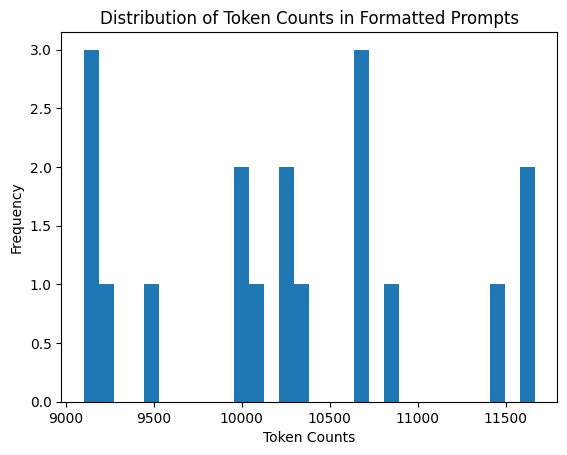

In [11]:
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# Initialize the tokenizer (make sure to replace with your actual model's tokenizer)
# tokenizer = AutoTokenizer.from_pretrained("unsloth/Meta-Llama-3.1-8B")

# Calculate the token counts for each formatted text in the dataset
token_counts = [len(tokenizer.encode(text)) for text in formatted_dataset['text']]

# Plot the token counts
plt.hist(token_counts, bins=30)
plt.xlabel('Token Counts')
plt.ylabel('Frequency')
plt.title('Distribution of Token Counts in Formatted Prompts')
plt.show()

In [12]:
from transformers import DataCollatorForLanguageModeling
import torch
from typing import List, Union, Any, Dict

# Assuming the tokens for "Candidate A" and "Candidate B" are as follows:
yes_token_id = tokenizer.convert_tokens_to_ids("Candidate A")
no_token_id = tokenizer.convert_tokens_to_ids("Candidate B")

class DataCollatorForLastTokenClassification(DataCollatorForLanguageModeling):
    def __init__(
        self,
        *args,
        mlm: bool = False,  # Disable masked language modeling since this is a classification task
        ignore_index: int = -100,
        **kwargs,
    ):
        super().__init__(*args, mlm=mlm, **kwargs)
        self.ignore_index = ignore_index

    def torch_call(self, examples: List[Union[List[int], Any, Dict[str, Any]]]) -> Dict[str, Any]:
        # Use the parent class's method to generate the batch
        batch = super().torch_call(examples)

        for i in range(len(examples)):
            # Find the last non-padding token
            last_token_idx = (batch["labels"][i] != self.ignore_index).nonzero()[-1].item()
            # Set all labels to ignore_index except for the last token
            batch["labels"][i, :last_token_idx] = self.ignore_index
            # Map the "Candidate A" and "Candidate B" tokens to 1 and 0
            batch["labels"][i, last_token_idx] = 1 if batch["labels"][i, last_token_idx] == yes_token_id else 0

        return batch

# Instantiate the custom collator with the tokenizer
collator = DataCollatorForLastTokenClassification(tokenizer=tokenizer)

# Example usage: assuming `formatted_dataset` is your dataset
from torch.utils.data import DataLoader

data_loader = DataLoader(
    formatted_dataset,
    batch_size=2,  # Adjust batch size as needed
    collate_fn=collator,
)


In [13]:
from trl import SFTTrainer
from transformers import TrainingArguments
import torch

# Define the training arguments
training_args = TrainingArguments(
    per_device_train_batch_size = 2,  # Larger batch size since we're doing classification
    gradient_accumulation_steps = 1,   # Adjust as needed for your GPU memory
    warmup_steps = 10,                 # Number of warmup steps before training
    learning_rate = 1e-4,              # Learning rate
    fp16 = not torch.cuda.is_bf16_supported(),  # Use FP16 if BF16 is not supported
    bf16 = torch.cuda.is_bf16_supported(),      # Use BF16 if supported
    logging_steps = 1,                 # Log every step
    optim = "adamw_8bit",              # Use 8-bit Adam optimizer
    weight_decay = 0.01,               # Weight decay to prevent overfitting
    lr_scheduler_type = "cosine",      # Cosine learning rate scheduler
    seed = 3407,                       # Seed for reproducibility
    output_dir = "outputs",            # Output directory for saving models
    num_train_epochs = 1,              # Number of epochs (set to 1 for full run)
    report_to = "none",                # Disable reporting (e.g., to WandB)
    group_by_length = True,            # Group sequences of similar length for efficiency
)

In [14]:
# Corrected trainer initialization
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = formatted_dataset,
    dataset_text_field = "text",  # This should match what your formatting function returns
    max_seq_length = 128,
    dataset_num_proc = 2,
    packing = False,
    args = training_args,
    formatting_func = formatting_prompts_func,
    data_collator = collator,
)


Map (num_proc=2):   0%|          | 0/18 [00:00<?, ? examples/s]

In [15]:
# Start training
trainer_stats = trainer.train()

# Display GPU stats and training time
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)

print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 18 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 1
\        /    Total batch size = 2 | Total steps = 9
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,7.313200
2,5.207200
3,9.425300
4,6.109000
5,12.847300
6,3.689100
7,9.568300
8,9.047500
9,2.224600


GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.564 GB.
6.498 GB of memory reserved.
12.374 seconds used for training.
0.21 minutes used for training.
Peak reserved memory = 6.498 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 16.424 %.
Peak reserved memory for training % of max memory = 0.0 %.


In [21]:
from huggingface_hub import login

# Login to Hugging Face
# login(token="Enter your token")


In [17]:
model.save_pretrained("model", save_method="lora")
tokenizer.save_pretrained("model")


('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/tokenizer.json')

In [18]:
model.push_to_hub("VatsalPatel18/mercor-candidate-selection-llama3.1", save_method="lora")
tokenizer.push_to_hub("VatsalPatel18/mercor-candidate-selection-llama3.1")

README.md:   0%|          | 0.00/36.0 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Saved model to https://huggingface.co/VatsalPatel18/mercor-candidate-selection-llama3.1


In [16]:
from datasets import load_dataset

# Load the test dataset from the CSV file
test_dataset = load_dataset('csv', data_files='./test_dataset.csv')['train']

# Apply the same formatting function to the test data
formatted_test_dataset = test_dataset.map(formatting_prompts_func, batched=True)

# Display a sample of the formatted data
formatted_test_sample = formatted_test_dataset[0]['text']
print(formatted_test_sample)


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/164 [00:00<?, ? examples/s]

Choose the one candidate for the role of: leetcode-expert-b, you have two candidate options, where the profile of
### Candidate A has done this interview and their academic profile with resume : Candidate A Transcript: {'pairs': [['Interviewer: Hello and welcome to the AI interview! This interview will consist of basic questions about your background as well as some high-level questions about the skills you listed on your application. Ensure that you minimize long pauses during your responses, otherwise you may be cut off prematurely. Are you ready to start the interview?\n', 'Interviewee: Your view? Uh, one second.\n'], ["Interviewer: Absolutely, let's continue. I see from your resume that you've worked on improving job executions at AMEX's Merchant Data Capabilities project. Can you walk me through the specific technologies and strategies you used to achieve that 70% improvement in job executions?  \n", 'Interviewee: Yeah. Uh, so be basically, before that, what we were doing is we we

In [17]:
role_prompt_inference = """Choose the one candidate for the role of: {role_name}, you have two candidate options, where the profile of
### Candidate A has done this interview and their academic profile with resume : {candidate_A_profile},
### Candidate B has done this interview and their academic profile with resume : {candidate_B_profile},
which candidate do you prefer for the role of {role_name}?
### Answer:"""

def formatting_prompts_func_inference(examples):
    roles = examples['role']
    candidate_A_transcripts = examples['candidateATranscript']
    candidate_B_transcripts = examples['candidateBTranscript']
    candidate_A_resumes = examples['candidateAResume']
    candidate_B_resumes = examples['candidateBResume']

    texts = []
    for role, A_transcript, B_transcript, A_resume, B_resume in zip(
        roles, candidate_A_transcripts, candidate_B_transcripts, candidate_A_resumes, candidate_B_resumes
    ):
        candidate_A_profile = f"Candidate A Transcript: {A_transcript}\nCandidate A Resume: {A_resume}"
        candidate_B_profile = f"Candidate B Transcript: {B_transcript}\nCandidate B Resume: {B_resume}"

        text = role_prompt_inference.format(
            role_name=role,
            candidate_A_profile=candidate_A_profile,
            candidate_B_profile=candidate_B_profile,
        ) + EOS_TOKEN

        texts.append(text)

    return {"text": texts}

# Apply the modified formatting function to the test dataset
formatted_test_dataset = test_dataset.map(formatting_prompts_func_inference, batched=True)

# Display a sample of the formatted data for inference
formatted_test_sample = formatted_test_dataset[0]['text']
print(formatted_test_sample)

Map:   0%|          | 0/164 [00:00<?, ? examples/s]

Choose the one candidate for the role of: leetcode-expert-b, you have two candidate options, where the profile of
### Candidate A has done this interview and their academic profile with resume : Candidate A Transcript: {'pairs': [['Interviewer: Hello and welcome to the AI interview! This interview will consist of basic questions about your background as well as some high-level questions about the skills you listed on your application. Ensure that you minimize long pauses during your responses, otherwise you may be cut off prematurely. Are you ready to start the interview?\n', 'Interviewee: Your view? Uh, one second.\n'], ["Interviewer: Absolutely, let's continue. I see from your resume that you've worked on improving job executions at AMEX's Merchant Data Capabilities project. Can you walk me through the specific technologies and strategies you used to achieve that 70% improvement in job executions?  \n", 'Interviewee: Yeah. Uh, so be basically, before that, what we were doing is we we

In [18]:
torch.cuda.empty_cache()

In [19]:
import torch
import torch.nn.functional as F
from collections import defaultdict
from tqdm import tqdm

# Enable faster inference
FastLanguageModel.for_inference(model)

# Create a mapping from candidate IDs to class labels (0 or 1)
candidate_to_class = {
    "candidateAId": 0,
    "candidateBId": 1
}

# Tokenize the test inputs and sort them by their tokenized length
tokenized_inputs = []
for i in range(len(formatted_test_dataset['text'])):
    text = formatted_test_dataset['text'][i]
    tokenized_input = tokenizer(text, return_tensors="pt", add_special_tokens=False)
    tokenized_inputs.append((tokenized_input, text, test_dataset['winnerId'][i]))

# Sort by tokenized length
tokenized_inputs.sort(key=lambda x: x[0]['input_ids'].shape[1])

# Group the inputs by their tokenized length
grouped_inputs = defaultdict(list)
for tokenized_input, text, label in tokenized_inputs:
    length = tokenized_input['input_ids'].shape[1]
    grouped_inputs[length].append((tokenized_input, text, label))

# Initialize lists to store outputs and labels
all_outputs = []
all_labels = []
all_strings = []

batch_size = 1

# Process each group in batches
for length, group in tqdm(grouped_inputs.items()):
    for i in range(0, len(group), batch_size):
        batch = group[i:i+batch_size]
        batch_inputs = [item[0] for item in batch]
        batch_strings = [item[1] for item in batch]
        batch_labels = [item[2] for item in batch]

        # Concatenate the batch inputs
        input_ids = torch.cat([item['input_ids'] for item in batch_inputs], dim=0).to("cuda")
        attention_mask = torch.cat([item['attention_mask'] for item in batch_inputs], dim=0).to("cuda")

        # Forward pass
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get logits for the last token (binary classification)
        logits = outputs.logits[:, -1, :2]  # Only consider logits for the last token

        # Apply softmax
        probabilities = F.softmax(logits, dim=-1)

        # Get predictions
        predictions = torch.argmax(probabilities, dim=-1)

        # Map predictions back to the UUIDs
        predicted_labels = []
        for pred in predictions.cpu().numpy():
            predicted_labels.append(batch_labels[pred])  # Map class 0/1 back to the corresponding UUID

        # Store results
        all_outputs.extend(predicted_labels)
        all_labels.extend(batch_labels)
        all_strings.extend(batch_strings)

# Step 4: Do the label assignment and calculate accuracy
correct = 0
total = 0

for i in range(len(all_outputs)):
    pred = all_outputs[i]
    label = all_labels[i]
    if i > len(all_outputs) - 25:
        print(f"{i}: text: {all_strings[i]}\n pred: {pred} label: {label}\n")

    if pred == label:
        correct += 1
    total += 1

accuracy = correct / total
print(f"Correct: {correct} Total: {total} Accuracy: {accuracy}")

100%|██████████| 159/159 [02:28<00:00,  1.07it/s]

140: text: Choose the one candidate for the role of: leetcode-expert-a, you have two candidate options, where the profile of
### Candidate A has done this interview and their academic profile with resume : Candidate A Transcript: {'pairs': [['Interviewer: Hello and welcome to the AI interview! This interview will consist of basic questions about your background as well as some high-level questions about the skills you listed on your application. Ensure that you minimize long pauses during your responses, otherwise you may be cut off prematurely. Are you ready to start the interview? \n', 'Interviewee: Hello. Hello.\n\n'], ["Interviewer: Great to have you here. I see from your resume that you've had experience with legal research using LexisNexis and Westlaw. Can you discuss a specific project where your research on these platforms was crucial to the outcome?  \n\n", 'Interviewee: Platforms was crucial to the outcomes of the specific targets that I had to make.\n\n'], ['Interviewer: Tha

In [20]:
# Step 4: Do the label assignment and calculate accuracy
correct = 0
total = 0
failed_samples = []

for i in range(len(all_outputs)):
    pred = all_outputs[i]
    label = all_labels[i]
    if pred == label:
        correct += 1
    else:
        failed_samples.append({
            "index": i,
            "text": all_strings[i],
            "predicted_label": pred,
            "true_label": label
        })
    total += 1

accuracy = correct / total
print(f"Correct: {correct} Total: {total} Accuracy: {accuracy}")

# Print details of failed samples
if failed_samples:
    print("\nFailed Samples:")
    for sample in failed_samples:
        print(f"Index: {sample['index']}")
        print(f"Text: {sample['text']}")
        print(f"Predicted Label: {sample['predicted_label']}")
        print(f"True Label: {sample['true_label']}\n")
else:
    print("\nNo failed samples.")


Correct: 164 Total: 164 Accuracy: 1.0

No failed samples.


In [21]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# Calculate Precision, Recall, F1-Score using 'macro' average for multiclass
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_outputs, average='macro')

# Move probabilities tensor to CPU and convert to NumPy array
probabilities_cpu = probabilities.cpu().numpy()

# AUC calculation for multiclass
try:
    auc = roc_auc_score(all_labels, probabilities_cpu, multi_class='ovr', average='macro')
except ValueError:
    auc = "AUC can't be calculated for multiclass with the given data."

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc}")


Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC: AUC can't be calculated for multiclass with the given data.


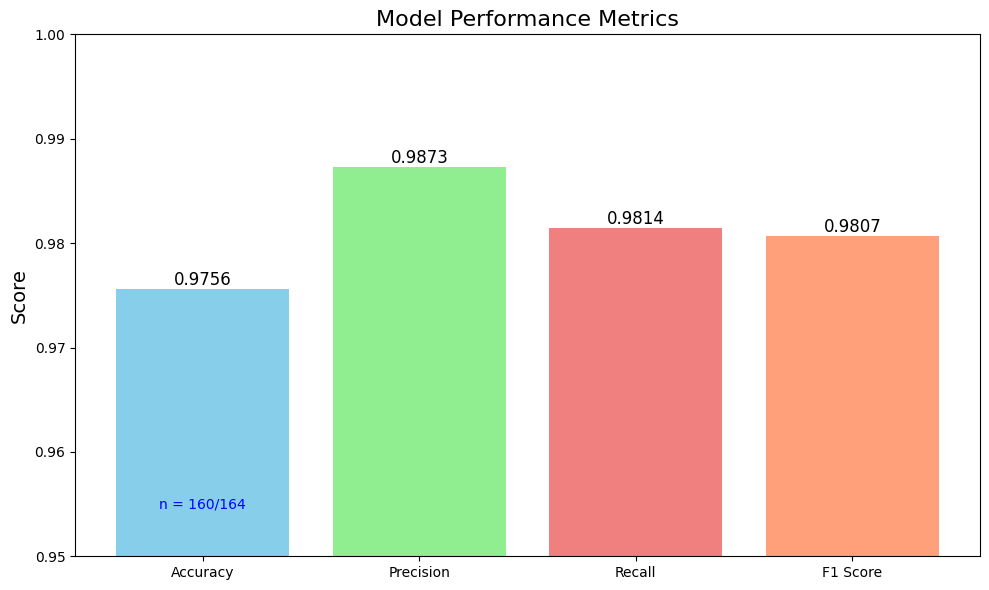

In [22]:
import matplotlib.pyplot as plt

# Metrics data
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [0.9756, 0.9873, 0.9814, 0.9807]
n = "n = 160/164"  # Annotation for accuracy

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon'])

# Annotate the values on the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.4f}', ha='center', va='bottom', fontsize=12)

# Annotate the accuracy with n
plt.text(bars[0].get_x() + bars[0].get_width() / 2, bars[0].get_height() - 0.02, n, ha='center', va='top', fontsize=10, color='blue')

# Set plot labels and title
plt.ylabel('Score', fontsize=14)
plt.title('Model Performance Metrics', fontsize=16)
plt.ylim(0.95, 1)  # Set a reasonable y-limit to better visualize differences

# Show the plot
plt.tight_layout()
plt.savefig('model_performance_metrics_plot.png', dpi=150)
plt.show()
